In [ ]:
import os
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.optim import Adam
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, random_split
import numpy as np

#Part1

In [ ]:
transform = transforms.Compose([
    # transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

In [ ]:

# Define paths for the dataset
sys_dir = ''
data_dir = os.path.join(sys_dir, 'shoes')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Load datasets
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)


In [ ]:
# Split train dataset into training and validation sets
train_size = int(0.8 * len(full_train_dataset))  # 80% for training
val_size = len(full_train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Print dataset sizes
print(f"Full training dataset size: {len(full_train_dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Full training dataset size: 721
Training set size: 576
Validation set size: 145
Test set size: 114


In [ ]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Image dimensions: torch.Size([3, 240, 240])


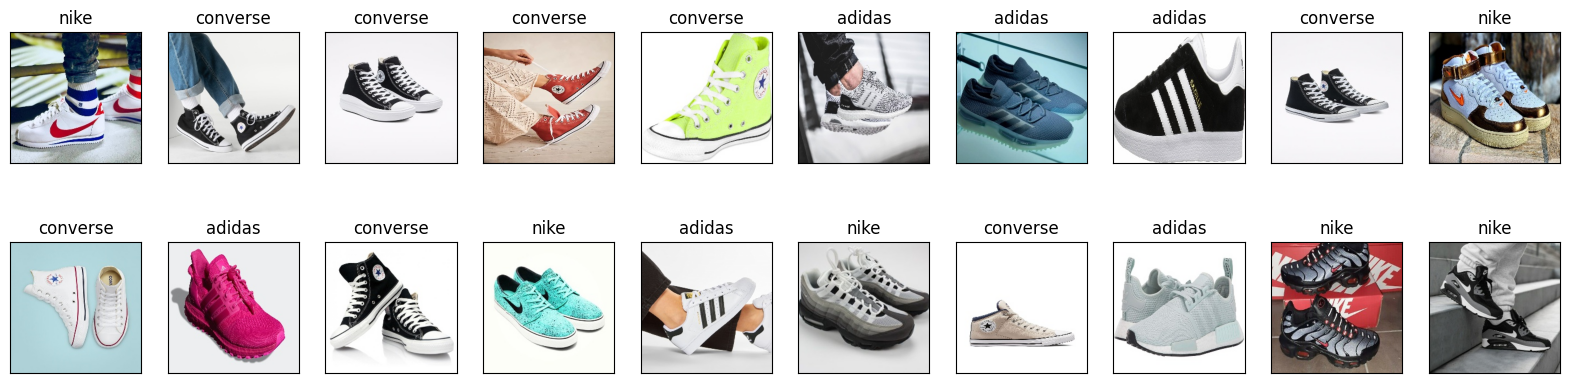

In [ ]:
# Function to display an image
def RGBshow(img):
    img = img * 0.5 + 0.5  # Unnormalize the image
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # Transpose to HWC format

# Fetch a single batch from the data loader
image_dataiter = iter(train_loader)  # Create an iterator from train_loader
imgs, labels = next(image_dataiter)  # Fetch the next batch (batch_size images)

# Plot the images in a grid
fig = plt.figure(figsize=(20, 5))  # Adjust figure size
for idx in range(min(len(imgs), 20)):  # Show up to 20 images
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    RGBshow(imgs[idx])
    ax.set_title(full_train_dataset.classes[labels[idx]])  # Use class names from the dataset

# Print image dimensions
print("Image dimensions:", imgs[0].shape)


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layers without Batch Normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Placeholder for fully connected layers, initialized in the first forward pass
        self.fc1 = None
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=3)  # 3 classes (adidas, converse, nike)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = self.pool3(nn.functional.relu(self.conv3(x)))
        x = self.pool4(nn.functional.relu(self.conv4(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Initialize fc1 dynamically on the first forward pass
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 256).to(x.device)

        # Fully connected layers
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = CNN()
model.to(device)

print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
# Adjust optimizer with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


In [ ]:
# Training loop
n_epochs = 15
history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    print(f"Epoch {epoch+1}/{n_epochs}")
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = 100 * train_correct / train_total
    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    for images, labels in tqdm(val_loader, desc="Validation", leave=False):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss /= len(val_loader)

    history['train_loss'].append(train_loss)
    history['valid_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

# Save the model
torch.save(model.state_dict(), 'shoe_classifier.pth')

Epoch 1/15


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.1007, Train Accuracy: 33.51%, Val Loss: 1.0982, Val Accuracy: 34.48%
Epoch 2/15


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0924, Train Accuracy: 39.58%, Val Loss: 1.1079, Val Accuracy: 34.48%
Epoch 3/15


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0754, Train Accuracy: 39.93%, Val Loss: 1.1039, Val Accuracy: 39.31%
Epoch 4/15


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0631, Train Accuracy: 42.88%, Val Loss: 1.1041, Val Accuracy: 43.45%
Epoch 5/15


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0455, Train Accuracy: 47.92%, Val Loss: 1.1164, Val Accuracy: 39.31%
Epoch 6/15


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0328, Train Accuracy: 48.61%, Val Loss: 1.0960, Val Accuracy: 40.00%
Epoch 7/15


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0243, Train Accuracy: 48.09%, Val Loss: 1.0971, Val Accuracy: 42.76%
Epoch 8/15


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0020, Train Accuracy: 53.12%, Val Loss: 1.0902, Val Accuracy: 42.76%
Epoch 9/15


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.9500, Train Accuracy: 55.21%, Val Loss: 1.0756, Val Accuracy: 42.76%
Epoch 10/15


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.9460, Train Accuracy: 55.90%, Val Loss: 1.0444, Val Accuracy: 42.07%
Epoch 11/15


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.9405, Train Accuracy: 54.86%, Val Loss: 1.0747, Val Accuracy: 44.83%
Epoch 12/15


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8734, Train Accuracy: 59.90%, Val Loss: 1.0493, Val Accuracy: 45.52%
Epoch 13/15


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8207, Train Accuracy: 63.37%, Val Loss: 1.0521, Val Accuracy: 48.28%
Epoch 14/15


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7897, Train Accuracy: 65.10%, Val Loss: 1.0070, Val Accuracy: 51.03%
Epoch 15/15


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7403, Train Accuracy: 65.10%, Val Loss: 1.0224, Val Accuracy: 51.03%


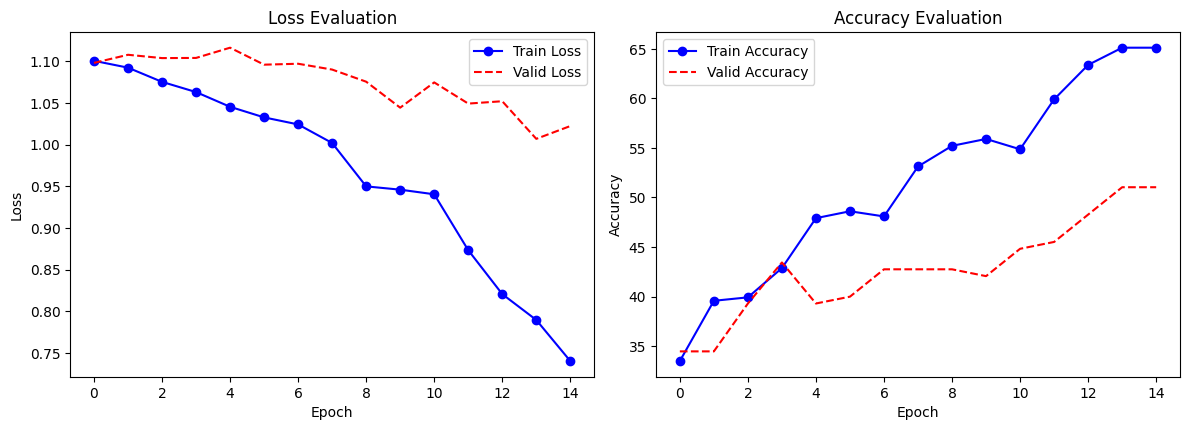

In [ ]:
# Plot training history
fig = plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], 'bo-', label='Train Loss')
plt.plot(history['valid_loss'], 'r--', label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evaluation')

plt.subplot(2, 2, 2)
plt.plot(history['train_acc'], 'bo-', label='Train Accuracy')
plt.plot(history['valid_acc'], 'r--', label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evaluation')

plt.tight_layout()
plt.show()

In [ ]:
# Test the model
model.load_state_dict(torch.load('shoe_classifier.pth'))
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for data, target in tqdm(test_loader, desc="Testing"):
        data, target = data.to(device), target.to(device)
        # Forward pass
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)
        # Update accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

# Calculate average test loss and accuracy
test_loss = test_loss / len(test_loader.dataset)
test_acc = 100 * test_correct / test_total

# Print test statistics
print(f'Test Loss: {test_loss:.6f} - Test Accuracy: {test_acc:.2f}%')

# Add to history
history['test_loss'] = test_loss
history['test_acc'] = test_acc

<ipython-input-16-667c56c7f5d9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('shoe_classifier.pth'))


Testing:   0%|          | 0/4 [00:00<?, ?it/s]

Test Loss: 0.923415 - Test Accuracy: 57.02%


#Part2

In [ ]:
# Define transformations
train_transform = transforms.Compose([
    # transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Adding more augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

test_transform = transforms.Compose([
    # transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])




In [ ]:

# Define paths for the dataset
data_dir = os.path.join(GOOGLE_DRIVE_PATH, 'shoes')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Load datasets
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)


In [ ]:

# Get class names
class_names = full_train_dataset.classes
print(f"Classes: {class_names}")


Classes: ['adidas', 'converse', 'nike']


In [ ]:
# Split train dataset into training and validation sets
train_size = int(0.8 * len(full_train_dataset))  # 80% for training
val_size = len(full_train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Print dataset sizes
print(f"Full training dataset size: {len(full_train_dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Full training dataset size: 721
Training set size: 576
Validation set size: 145
Test set size: 114


In [ ]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

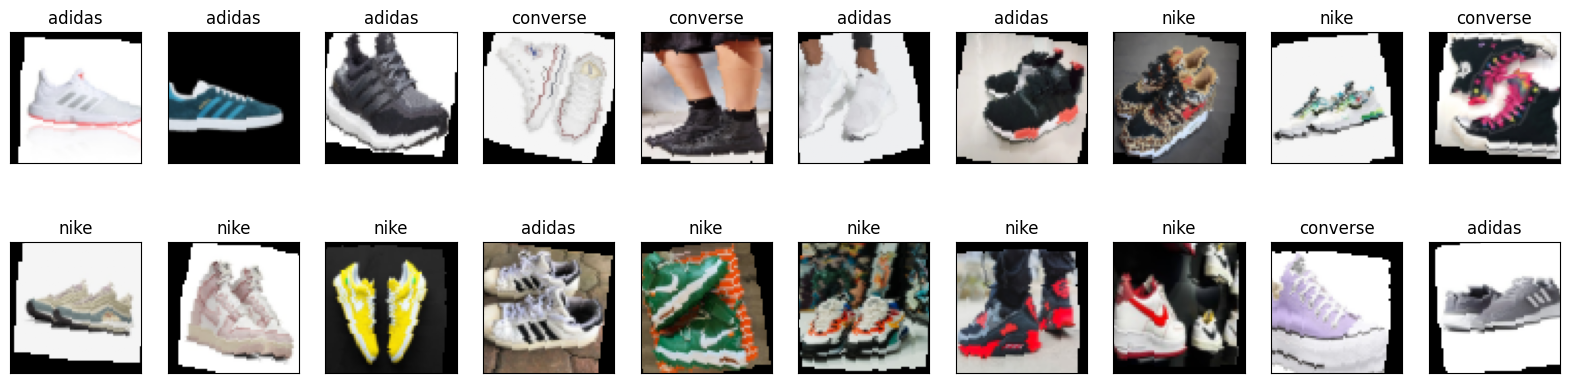

In [ ]:
# Function to display an image
def RGBshow(img):
    img = img * 0.5 + 0.5  # Unnormalize the image
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # Transpose to HWC format

# Fetch a single batch from the data loader
image_dataiter = iter(train_loader)  # Create an iterator from train_loader
imgs, labels = next(image_dataiter)  # Fetch the next batch (batch_size images)

# Plot the images in a grid
fig = plt.figure(figsize=(20, 5))  # Adjust figure size
for idx in range(min(len(imgs), 20)):  # Show up to 20 images
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    RGBshow(imgs[idx])
    ax.set_title(full_train_dataset.classes[labels[idx]])  # Use class names from the dataset

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layers with Batch Normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers with Dropout
        self.fc1 = nn.Linear(in_features=64 * 8 * 8, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)  # 3 classes (adidas, converse, nike)
        self.fc3 = nn.Linear(in_features=128, out_features=3)  # 3 classes (adidas, converse, nike)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = self.pool(self.bn1(nn.functional.relu(self.conv1(x))))
        x = self.pool(self.bn2(nn.functional.relu(self.conv2(x))))
        x = self.pool(self.bn3(nn.functional.relu(self.conv3(x))))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = CNN()
model.to(device)

print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
# Adjust optimizer with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


In [ ]:
# Training loop
n_epochs = 30
history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    print(f"Epoch {epoch+1}/{n_epochs}")
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = 100 * train_correct / train_total
    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    for images, labels in tqdm(val_loader, desc="Validation", leave=False):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss /= len(val_loader)

    history['train_loss'].append(train_loss)
    history['valid_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

# Save the model
torch.save(model.state_dict(), 'shoe_classifier.pth')

Epoch 1/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.1844, Train Accuracy: 32.64%, Val Loss: 4.6158, Val Accuracy: 10.34%
Epoch 2/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.2834, Train Accuracy: 40.97%, Val Loss: 1.2090, Val Accuracy: 40.69%
Epoch 3/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.1634, Train Accuracy: 42.88%, Val Loss: 1.0649, Val Accuracy: 41.38%
Epoch 4/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0865, Train Accuracy: 48.09%, Val Loss: 1.0733, Val Accuracy: 46.21%
Epoch 5/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0892, Train Accuracy: 45.83%, Val Loss: 1.0500, Val Accuracy: 48.97%
Epoch 6/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0435, Train Accuracy: 47.22%, Val Loss: 1.1373, Val Accuracy: 45.52%
Epoch 7/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0071, Train Accuracy: 50.17%, Val Loss: 1.1012, Val Accuracy: 37.24%
Epoch 8/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0540, Train Accuracy: 46.70%, Val Loss: 1.0677, Val Accuracy: 44.14%
Epoch 9/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0144, Train Accuracy: 51.22%, Val Loss: 1.0913, Val Accuracy: 38.62%
Epoch 10/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.9582, Train Accuracy: 54.51%, Val Loss: 1.0189, Val Accuracy: 57.24%
Epoch 11/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.9526, Train Accuracy: 53.30%, Val Loss: 1.0432, Val Accuracy: 46.90%
Epoch 12/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.9664, Train Accuracy: 54.34%, Val Loss: 1.0751, Val Accuracy: 46.90%
Epoch 13/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.9396, Train Accuracy: 55.03%, Val Loss: 0.9782, Val Accuracy: 55.17%
Epoch 14/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.9074, Train Accuracy: 55.90%, Val Loss: 1.0183, Val Accuracy: 52.41%
Epoch 15/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.9218, Train Accuracy: 55.56%, Val Loss: 1.0302, Val Accuracy: 52.41%
Epoch 16/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8767, Train Accuracy: 59.55%, Val Loss: 1.0181, Val Accuracy: 54.48%
Epoch 17/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.9025, Train Accuracy: 58.33%, Val Loss: 0.9741, Val Accuracy: 57.24%
Epoch 18/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8398, Train Accuracy: 61.81%, Val Loss: 1.0166, Val Accuracy: 51.72%
Epoch 19/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8157, Train Accuracy: 63.54%, Val Loss: 1.1349, Val Accuracy: 45.52%
Epoch 20/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7447, Train Accuracy: 67.36%, Val Loss: 1.0871, Val Accuracy: 50.34%
Epoch 21/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7575, Train Accuracy: 65.80%, Val Loss: 1.0578, Val Accuracy: 55.86%
Epoch 22/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7424, Train Accuracy: 66.49%, Val Loss: 1.1040, Val Accuracy: 54.48%
Epoch 23/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7253, Train Accuracy: 69.27%, Val Loss: 0.9703, Val Accuracy: 52.41%
Epoch 24/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6854, Train Accuracy: 71.53%, Val Loss: 1.0054, Val Accuracy: 54.48%
Epoch 25/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6408, Train Accuracy: 72.92%, Val Loss: 0.9349, Val Accuracy: 60.00%
Epoch 26/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6510, Train Accuracy: 72.22%, Val Loss: 1.0446, Val Accuracy: 57.93%
Epoch 27/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6138, Train Accuracy: 73.61%, Val Loss: 1.0196, Val Accuracy: 57.93%
Epoch 28/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6073, Train Accuracy: 73.96%, Val Loss: 1.0818, Val Accuracy: 58.62%
Epoch 29/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6213, Train Accuracy: 73.09%, Val Loss: 1.0474, Val Accuracy: 53.79%
Epoch 30/30


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6050, Train Accuracy: 73.78%, Val Loss: 0.9987, Val Accuracy: 57.93%


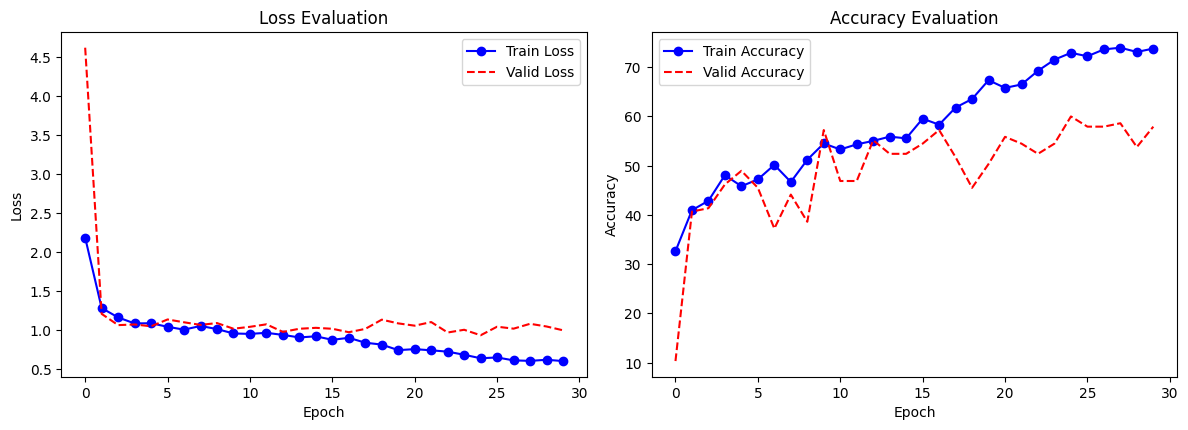

In [ ]:
# Plot training history
fig = plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], 'bo-', label='Train Loss')
plt.plot(history['valid_loss'], 'r--', label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evaluation')

plt.subplot(2, 2, 2)
plt.plot(history['train_acc'], 'bo-', label='Train Accuracy')
plt.plot(history['valid_acc'], 'r--', label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evaluation')

plt.tight_layout()
plt.show()

In [ ]:
# Test the model
model.load_state_dict(torch.load('shoe_classifier.pth'))
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for data, target in tqdm(test_loader, desc="Testing"):
        data, target = data.to(device), target.to(device)
        # Forward pass
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)
        # Update accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

# Calculate average test loss and accuracy
test_loss = test_loss / len(test_loader.dataset)
test_acc = 100 * test_correct / test_total

# Print test statistics
print(f'Test Loss: {test_loss:.6f} - Test Accuracy: {test_acc:.2f}%')

# Add to history
history['test_loss'] = test_loss
history['test_acc'] = test_acc

<ipython-input-199-667c56c7f5d9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('shoe_classifier.pth'))


Testing:   0%|          | 0/4 [00:00<?, ?it/s]

Test Loss: 0.909180 - Test Accuracy: 63.16%


#Part3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
%load_ext tensorboard
np.random.seed(42)

In [ ]:
# Define paths for the dataset
data_dir = os.path.join(GOOGLE_DRIVE_PATH, 'shoes')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [ ]:
batch_size = 32
img_size = (240, 240)

# create a training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
     shuffle=True, batch_size=batch_size, image_size=img_size,
    validation_split=0.2, subset='training', seed=42
)

# create a validation dataset
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True, batch_size=batch_size, image_size=img_size,
    validation_split=0.2, subset='validation', seed=42
)

# create a test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle=True, batch_size=batch_size, image_size=img_size
)

Found 721 files belonging to 3 classes.
Using 577 files for training.
Found 721 files belonging to 3 classes.
Using 144 files for validation.
Found 114 files belonging to 3 classes.


In [ ]:
class_names = train_dataset.class_names
class_names

['adidas', 'converse', 'nike']

In [ ]:
# load a base model
base_model = keras.applications.xception.Xception(input_shape=(224, 224, 3),
                                                  weights='imagenet',
                                                  include_top=False)

In [ ]:
# create an input layer
input = keras.layers.Input(shape=(240, 240, 3))

# resize and preprocess input images
resized_input = keras.layers.Resizing(224, 224)(input)
preprocessed_input = keras.applications.xception.preprocess_input(resized_input)

# add data augmentation layers to reduce overfitting and make data more diverse
flip = keras.layers.RandomFlip('horizontal')(preprocessed_input)
rotation = keras.layers.RandomRotation(0.2)(flip)
zoom = keras.layers.RandomZoom(0.2)(rotation)

# run preprocessed images through the base model
base_model_output = base_model(zoom)

# add a GlobalAveragePooling layer and a dropout layer to reduce overfitting
avg = keras.layers.GlobalAveragePooling2D()(base_model_output)
dropout = keras.layers.Dropout(0.2)(avg)

# add a fully connected layer with 3 nodes since the dataset has 3 classes
output = keras.layers.Dense(3, activation='softmax')(dropout)

# create a model
model = keras.Model(inputs=input, outputs=output)

In [ ]:
# unfreeze pretrained layers
for layer in base_model.layers:
    layer.trainable = True

# create an early stopping callback
early_stopping_callback = keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)

In [ ]:
# decrease a learning rate and compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])

# continue learning
history = model.fit(train_dataset, epochs=100,
                     validation_data=valid_dataset,
                     callbacks=[early_stopping_callback])

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 144s 6s/step - accuracy: 0.3933 - loss: 1.0941 - val_accuracy: 0.4583 - val_loss: 1.0628
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 672ms/step - accuracy: 0.4490 - loss: 1.0684 - val_accuracy: 0.4653 - val_loss: 1.0345
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 643ms/step - accuracy: 0.5122 - loss: 1.0236 - val_accuracy: 0.5000 - val_loss: 1.0014
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 643ms/step - accuracy: 0.5310 - loss: 1.0135 - val_accuracy: 0.5278 - val_loss: 0.9696
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 649ms/step - accuracy: 0.5927 - loss: 0.9496 - val_accuracy: 0.5486 - val_loss: 0.9344
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 652ms/step - accuracy: 0.6439 - loss: 0.9196 - val_accuracy: 0.5764 - val_loss: 0.9048
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 652ms/step - accuracy: 0.6938 - loss: 0.8760 - val_accuracy: 0.5972 - val_loss: 0.8782
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 653ms/step - accuracy: 0.7389 - loss: 0.8483 - va

In [ ]:
model.evaluate(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step - accuracy: 0.9209 - loss: 0.2753


[0.24384479224681854, 0.9298245906829834]